Import library dan dataset

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [100]:
df = pd.read_csv("/content/bbc-text.csv")
print("Row {}, Columns {}".format(df.shape[0], df.shape[1]))

Row 2225, Columns 2


In [101]:
df.sample()

,category,text
467,entertainment,dirty den s demise seen by 14m more than 14 mi...


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


Casefolding

In [102]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [103]:
df['text'] = df['text'].str.lower()
df.sample()

,category,text
1956,sport,trial date is set for balco case a us judge ha...


Removing Punctuation

In [104]:
df["text"] = df['text'].str.replace('[^\w\s]','')
df.sample()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,category,text
772,entertainment,redford s vision of sundance despite sporting ...


Removing Stopwords

In [105]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
stop_word = set(stopwords.words('english'))

df['text'] = df['text'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_word)]))

In [107]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [108]:
category = pd.get_dummies(df['category'])
df1 = pd.concat([df, category], axis=1)
df1 = df1.drop(columns='category')
df1.sample(3)

,text,business,entertainment,politics,sport,tech
1360,call centre users lose patience customers tryi...,1,0,0,0,0
480,edwards tips idowu euro gold world outdoor tri...,0,0,0,1,0
933,mutant book wins guardian prize book evolution...,0,1,0,0,0


In [109]:
df1.columns

Index(['text', 'business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')

In [110]:
X = df1['text'].values
y = df1[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Row and col : X_train {} | X_test {} | y_train {} | y_test {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Row and col : X_train (1780,) | X_test (445,) | y_train (1780, 5) | y_test (445, 5)


In [112]:
tokenizer = Tokenizer(num_words=8000, oov_token='x')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

maxlen = max([len(x) for x in sequences_train])

padded_train = pad_sequences(sequences_train, maxlen=maxlen)
padded_test = pad_sequences(sequences_test, maxlen=maxlen)

In [113]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(124, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [114]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          160000    
                                                                 
 lstm_10 (LSTM)              (None, None, 64)          24832     
                                                                 
 dropout_10 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 124)               8060      
                                                                 
 dense_17 (Dense)            (None, 64)                8000      
                                                                 
 dense_18 (Dense)            (None, 32)               

In [115]:
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='content',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [116]:
num_epochs = 50
history = model.fit(padded_train, y_train, epochs=num_epochs, 
                    validation_data=(padded_test, y_test), verbose=2,
                    callbacks=[model_checkpoint_callback, callbacks])

Epoch 1/50
56/56 - 10s - loss: 1.5529 - accuracy: 0.2747 - val_loss: 1.2364 - val_accuracy: 0.3933 - 10s/epoch - 182ms/step
Epoch 2/50
56/56 - 7s - loss: 1.1786 - accuracy: 0.4337 - val_loss: 1.0027 - val_accuracy: 0.5416 - 7s/epoch - 119ms/step
Epoch 3/50
56/56 - 6s - loss: 0.9108 - accuracy: 0.5719 - val_loss: 0.9048 - val_accuracy: 0.6045 - 6s/epoch - 107ms/step
Epoch 4/50
56/56 - 6s - loss: 0.7565 - accuracy: 0.6938 - val_loss: 0.8977 - val_accuracy: 0.5798 - 6s/epoch - 107ms/step
Epoch 5/50
56/56 - 6s - loss: 0.6408 - accuracy: 0.7444 - val_loss: 0.6941 - val_accuracy: 0.7393 - 6s/epoch - 108ms/step
Epoch 6/50
56/56 - 6s - loss: 0.9836 - accuracy: 0.7427 - val_loss: 1.0906 - val_accuracy: 0.5506 - 6s/epoch - 106ms/step
Epoch 7/50
56/56 - 6s - loss: 0.7035 - accuracy: 0.7545 - val_loss: 0.8081 - val_accuracy: 0.7326 - 6s/epoch - 107ms/step
Epoch 8/50
56/56 - 7s - loss: 0.3517 - accuracy: 0.8798 - val_loss: 0.7230 - val_accuracy: 0.8045 - 7s/epoch - 131ms/step
Epoch 9/50
56/56 - 6s 

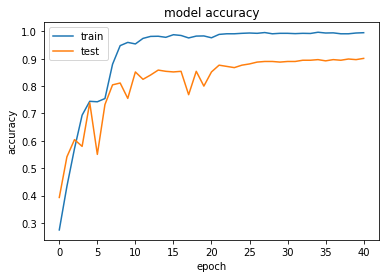

In [117]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

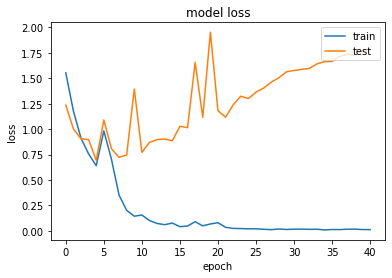

In [118]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()